In [14]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


# Define the columns to include in the new DataFrame
order_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Order Management CPU Usage',
    'Order Management Memory Usage',
    'Order Management Request Count',
    'Order Management 5xx Failures',
    'Order Management Pod Count'
]
product_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Product Catalog CPU Usage',
    'Product Catalog Memory Usage',
    'Product Catalog Request Count',
    'Product Catalog 5xx Failures',
    'Product Catalog Pod Count'
]
shipping_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Shipping Logistics CPU Usage',
    'Shipping Logistics Memory Usage',
    'Shipping Logistics Request Count',
    'Shipping Logistics 5xx Failures',
    'Shipping Logistics Pod Count'
]
user_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'User Account CPU Usage',
    'User Account Memory Usage',
    'User Account Request Count',
    'User Account 5xx Failures',
    'User Account Pod Count'
]
reviews_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Review Rating CPU Usage',
    'Review Rating Memory Usage',
    'Review Rating Request Count',
    'Review Rating 5xx Failures',
    'Review Rating Pod Count'
]
payment_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Payment Processing CPU Usage',
    'Payment Processing Memory Usage',
    'Payment Processing Request Count',
    'Payment Processing 5xx Failures',
    'Payment Processing Pod Count'
]

file_path = '~/Downloads/Collected Data - 15 Jan 23:59:00.csv'

# Creating dataframes for each service
order_df = pd.read_csv(file_path, usecols=order_columns_to_include)
product_df = pd.read_csv(file_path, usecols=product_columns_to_include)
user_df = pd.read_csv(file_path, usecols=user_columns_to_include)
reviews_df = pd.read_csv(file_path, usecols=reviews_columns_to_include)
shipping_df = pd.read_csv(file_path, usecols=shipping_columns_to_include)
payment_df = pd.read_csv(file_path, usecols=payment_columns_to_include)

order_df.fillna(0, inplace=True)
product_df.fillna(0, inplace=True)
user_df.fillna(0, inplace=True)
reviews_df.fillna(0, inplace=True)
shipping_df.fillna(0, inplace=True)
payment_df.fillna(0, inplace=True)


# Convert 'Timestamp [ms]' to datetime and set it as the index
order_df['Time'] = pd.to_datetime(order_df['Time'])
order_df.set_index('Time', inplace=True)
order_df['Time'] = order_df.index
order_df.head()

product_df['Time'] = pd.to_datetime(product_df['Time'])
product_df.set_index('Time', inplace=True)
product_df['Time'] = product_df.index
product_df.head()

user_df['Time'] = pd.to_datetime(user_df['Time'])
user_df.set_index('Time', inplace=True)
user_df['Time'] = user_df.index
user_df.head()

reviews_df['Time'] = pd.to_datetime(reviews_df['Time'])
reviews_df.set_index('Time', inplace=True)
reviews_df['Time'] = reviews_df.index
reviews_df.head()

shipping_df['Time'] = pd.to_datetime(shipping_df['Time'])
shipping_df.set_index('Time', inplace=True)
shipping_df['Time'] = shipping_df.index
shipping_df.head()

payment_df['Time'] = pd.to_datetime(payment_df['Time'])
payment_df.set_index('Time', inplace=True)
payment_df['Time'] = payment_df.index
payment_df.head()

order_df.head()

Cluster CPU  Cluster Memory  Order Management CPU Usage  \
Time                                                                           
2024-08-21 00:00:00         18.7            26.8                        83.7   
2024-08-21 00:01:00         19.8            27.0                        95.4   
2024-08-21 00:02:00         20.8            27.0                        87.5   
2024-08-21 00:03:00         20.7            27.0                        86.5   
2024-08-21 00:04:00         20.3            27.0                        83.8   

                     Order Management Memory Usage  \
Time                                                 
2024-08-21 00:00:00                           51.7   
2024-08-21 00:01:00                           51.6   
2024-08-21 00:02:00                           51.7   
2024-08-21 00:03:00                           51.8   
2024-08-21 00:04:00                           51.7   

                     Order Management Pod Count  \
Time                                              
2024-08-21 00:00:00                           4   
2024-08-21 00:01:00                           4   
2024-08-21 00:02:00                           4   
2024-08-21 00:03:00                           4   
2024-08-21 00:04:00                           4   

                     Order Management Request Count  \
Time                                                  
2024-08-21 00:00:00                          7320.0   
2024-08-21 00:01:00                          8318.0   
2024-08-21 00:02:00                          8660.0   
2024-08-21 00:03:00                          7706.0   
2024-08-21 00:04:00                          7354.0   

                     Order Management 5xx Failures                Time  
Time                                                                    
2024-08-21 00:00:00                            0.0 2024-08-21 00:00:00  
2024-08-21 00:01:00                            2.0 2024-08-21 00:01:00  
2024-08-21 00:02:00                            0.0 2024-08-21 00:02:00  
2024-08-21 00:03:00                            0.0 2024-08-21 00:03:00  
2024-08-21 00:04:00                            0.0 2024-08-21 00:04:00

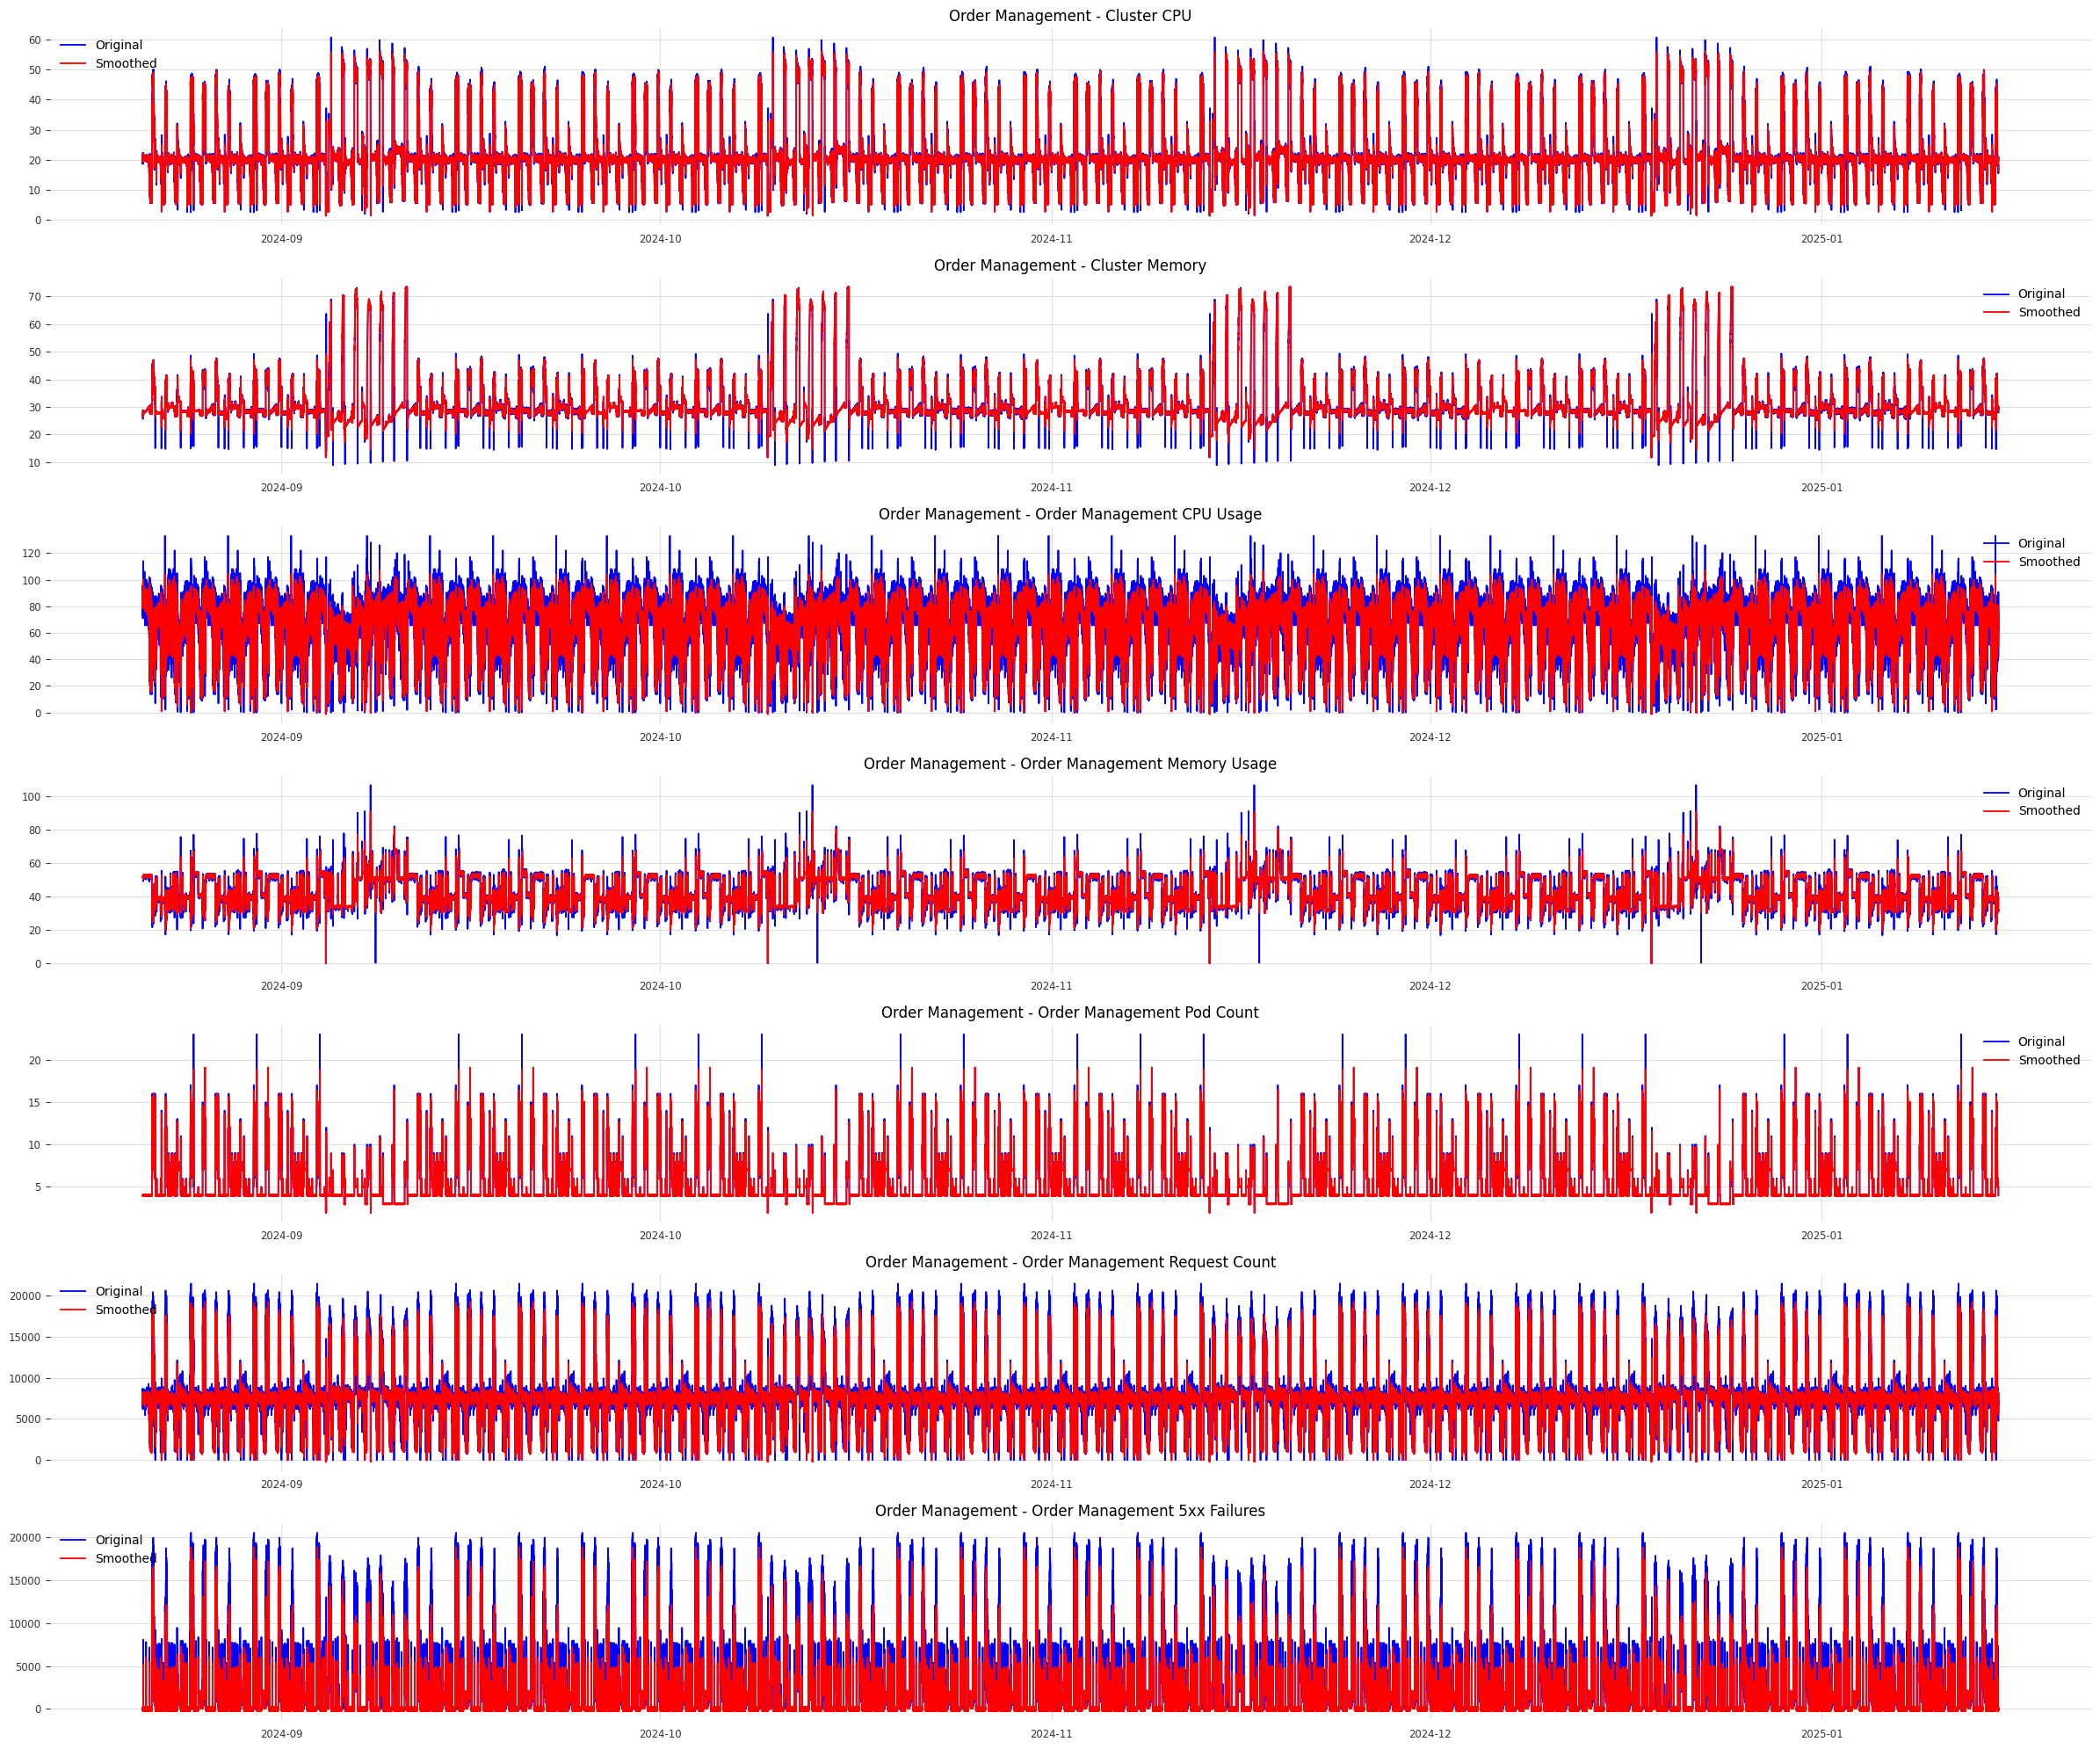

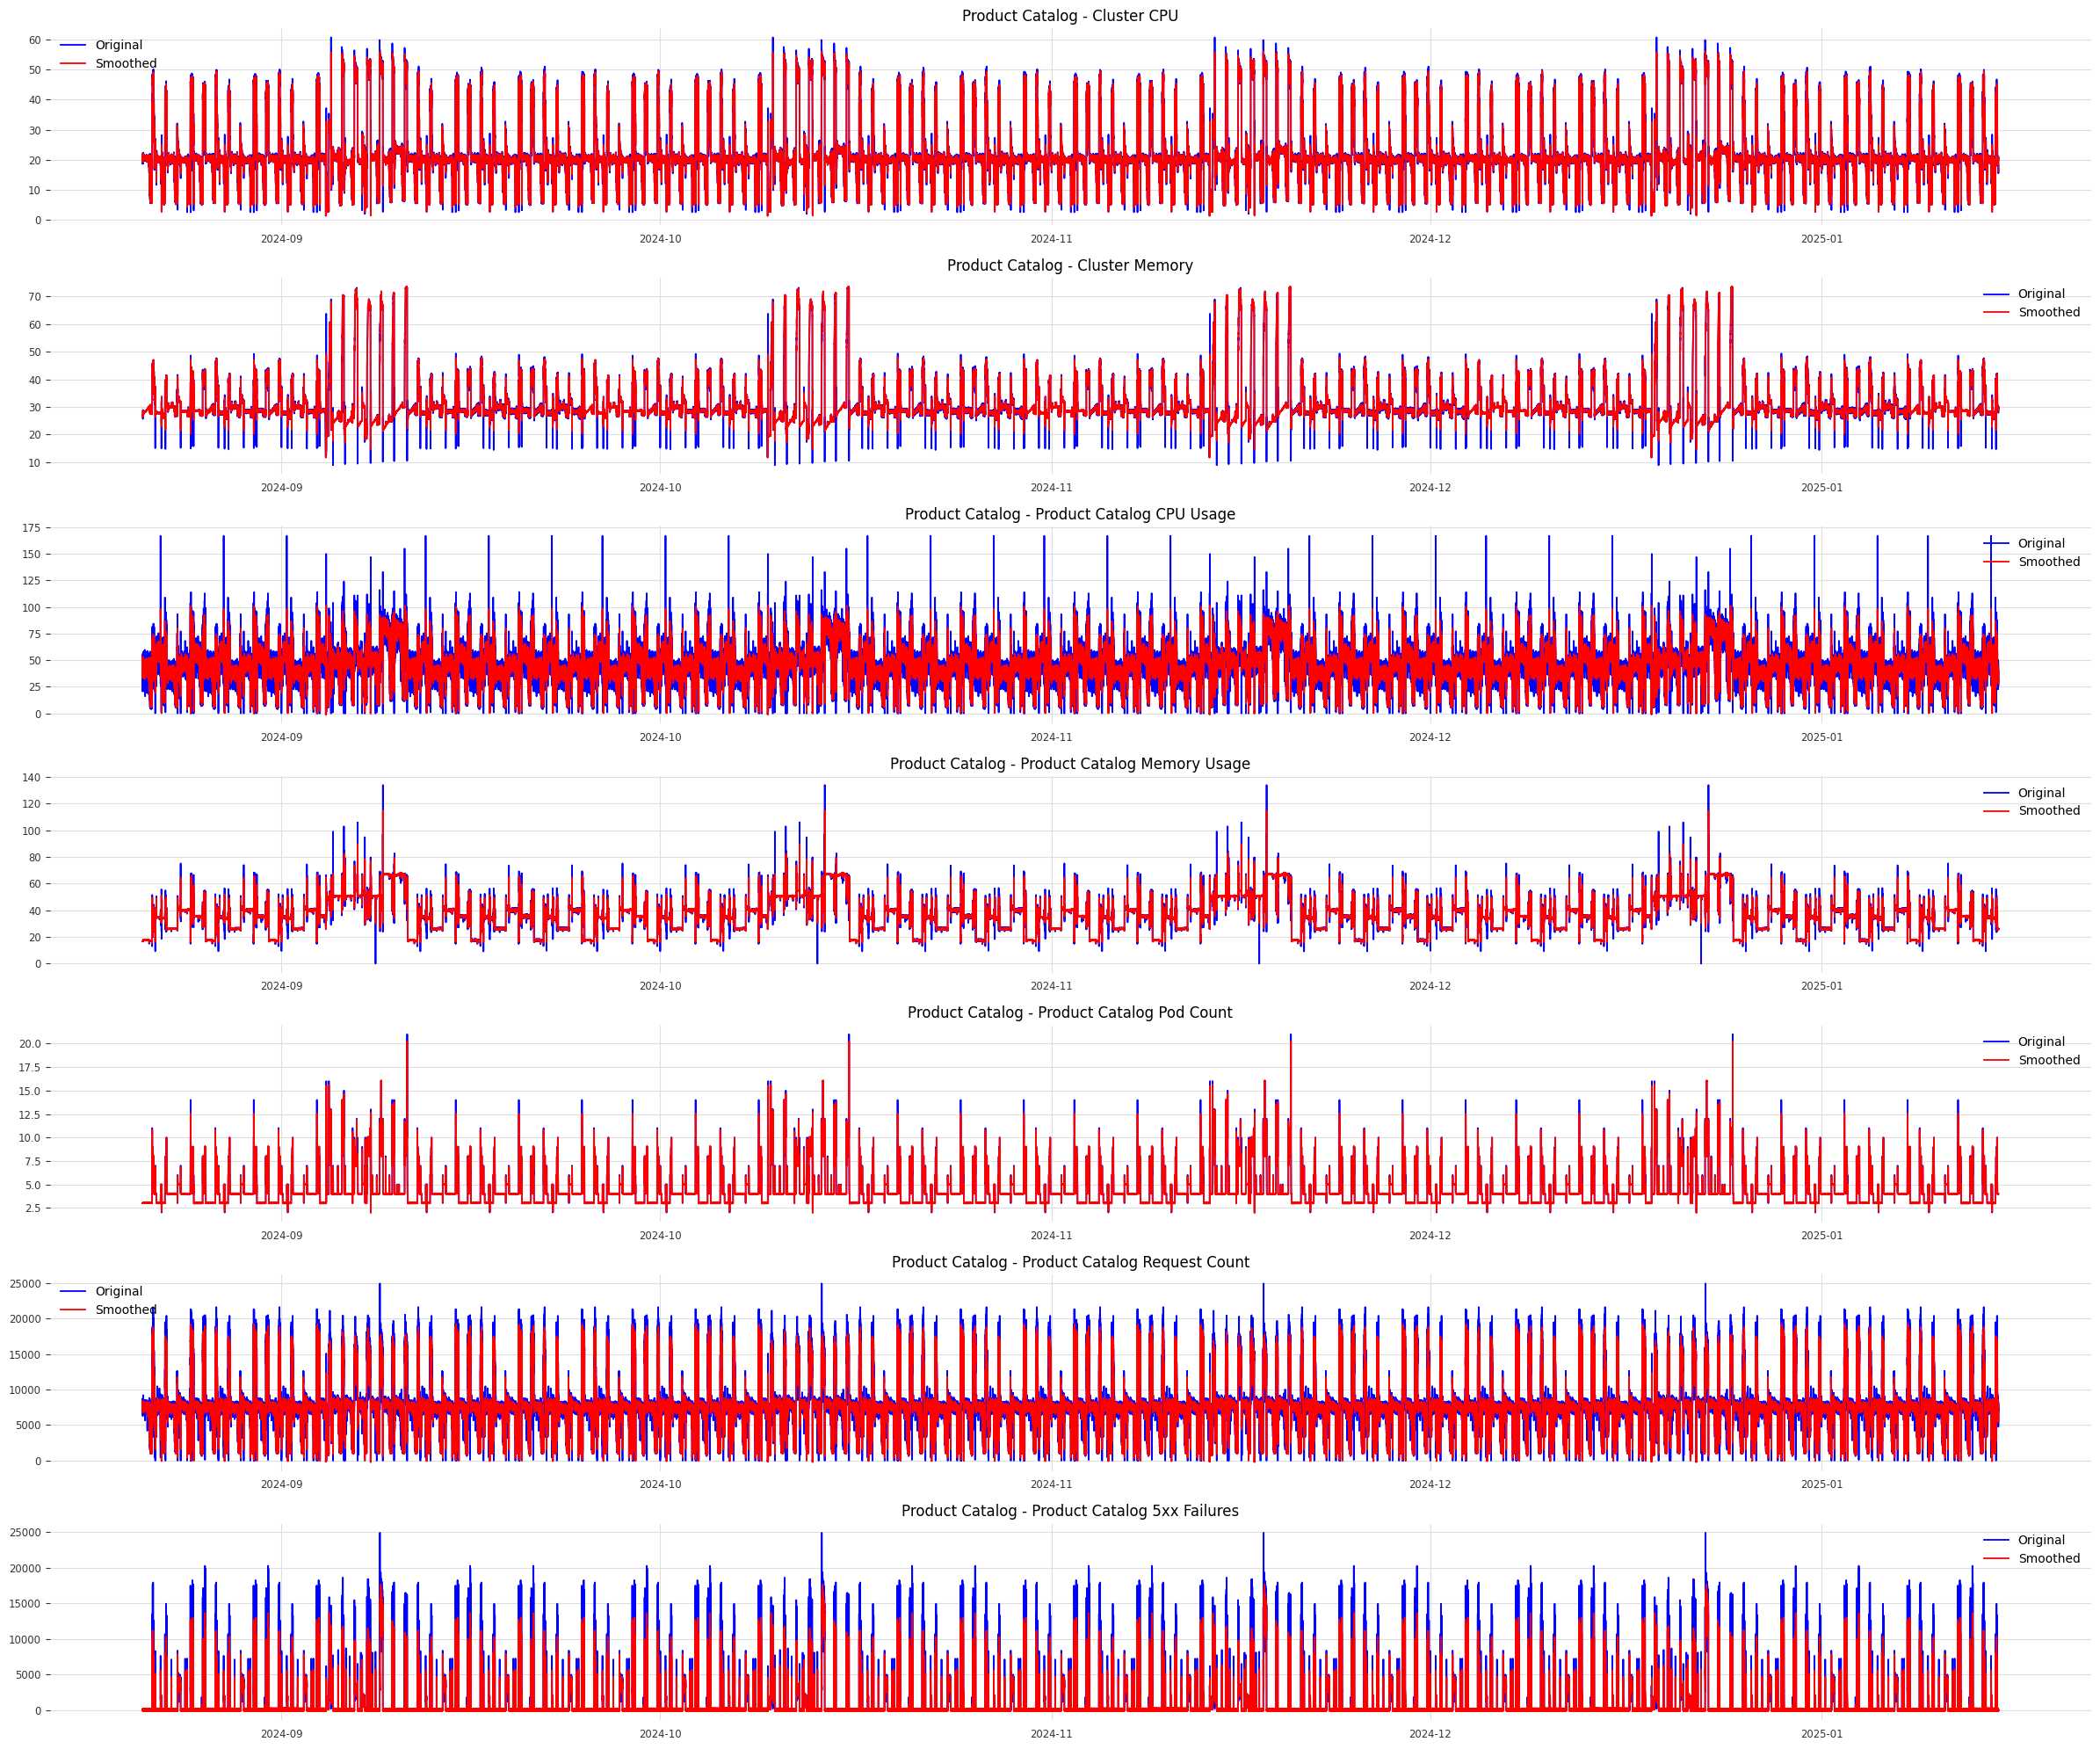

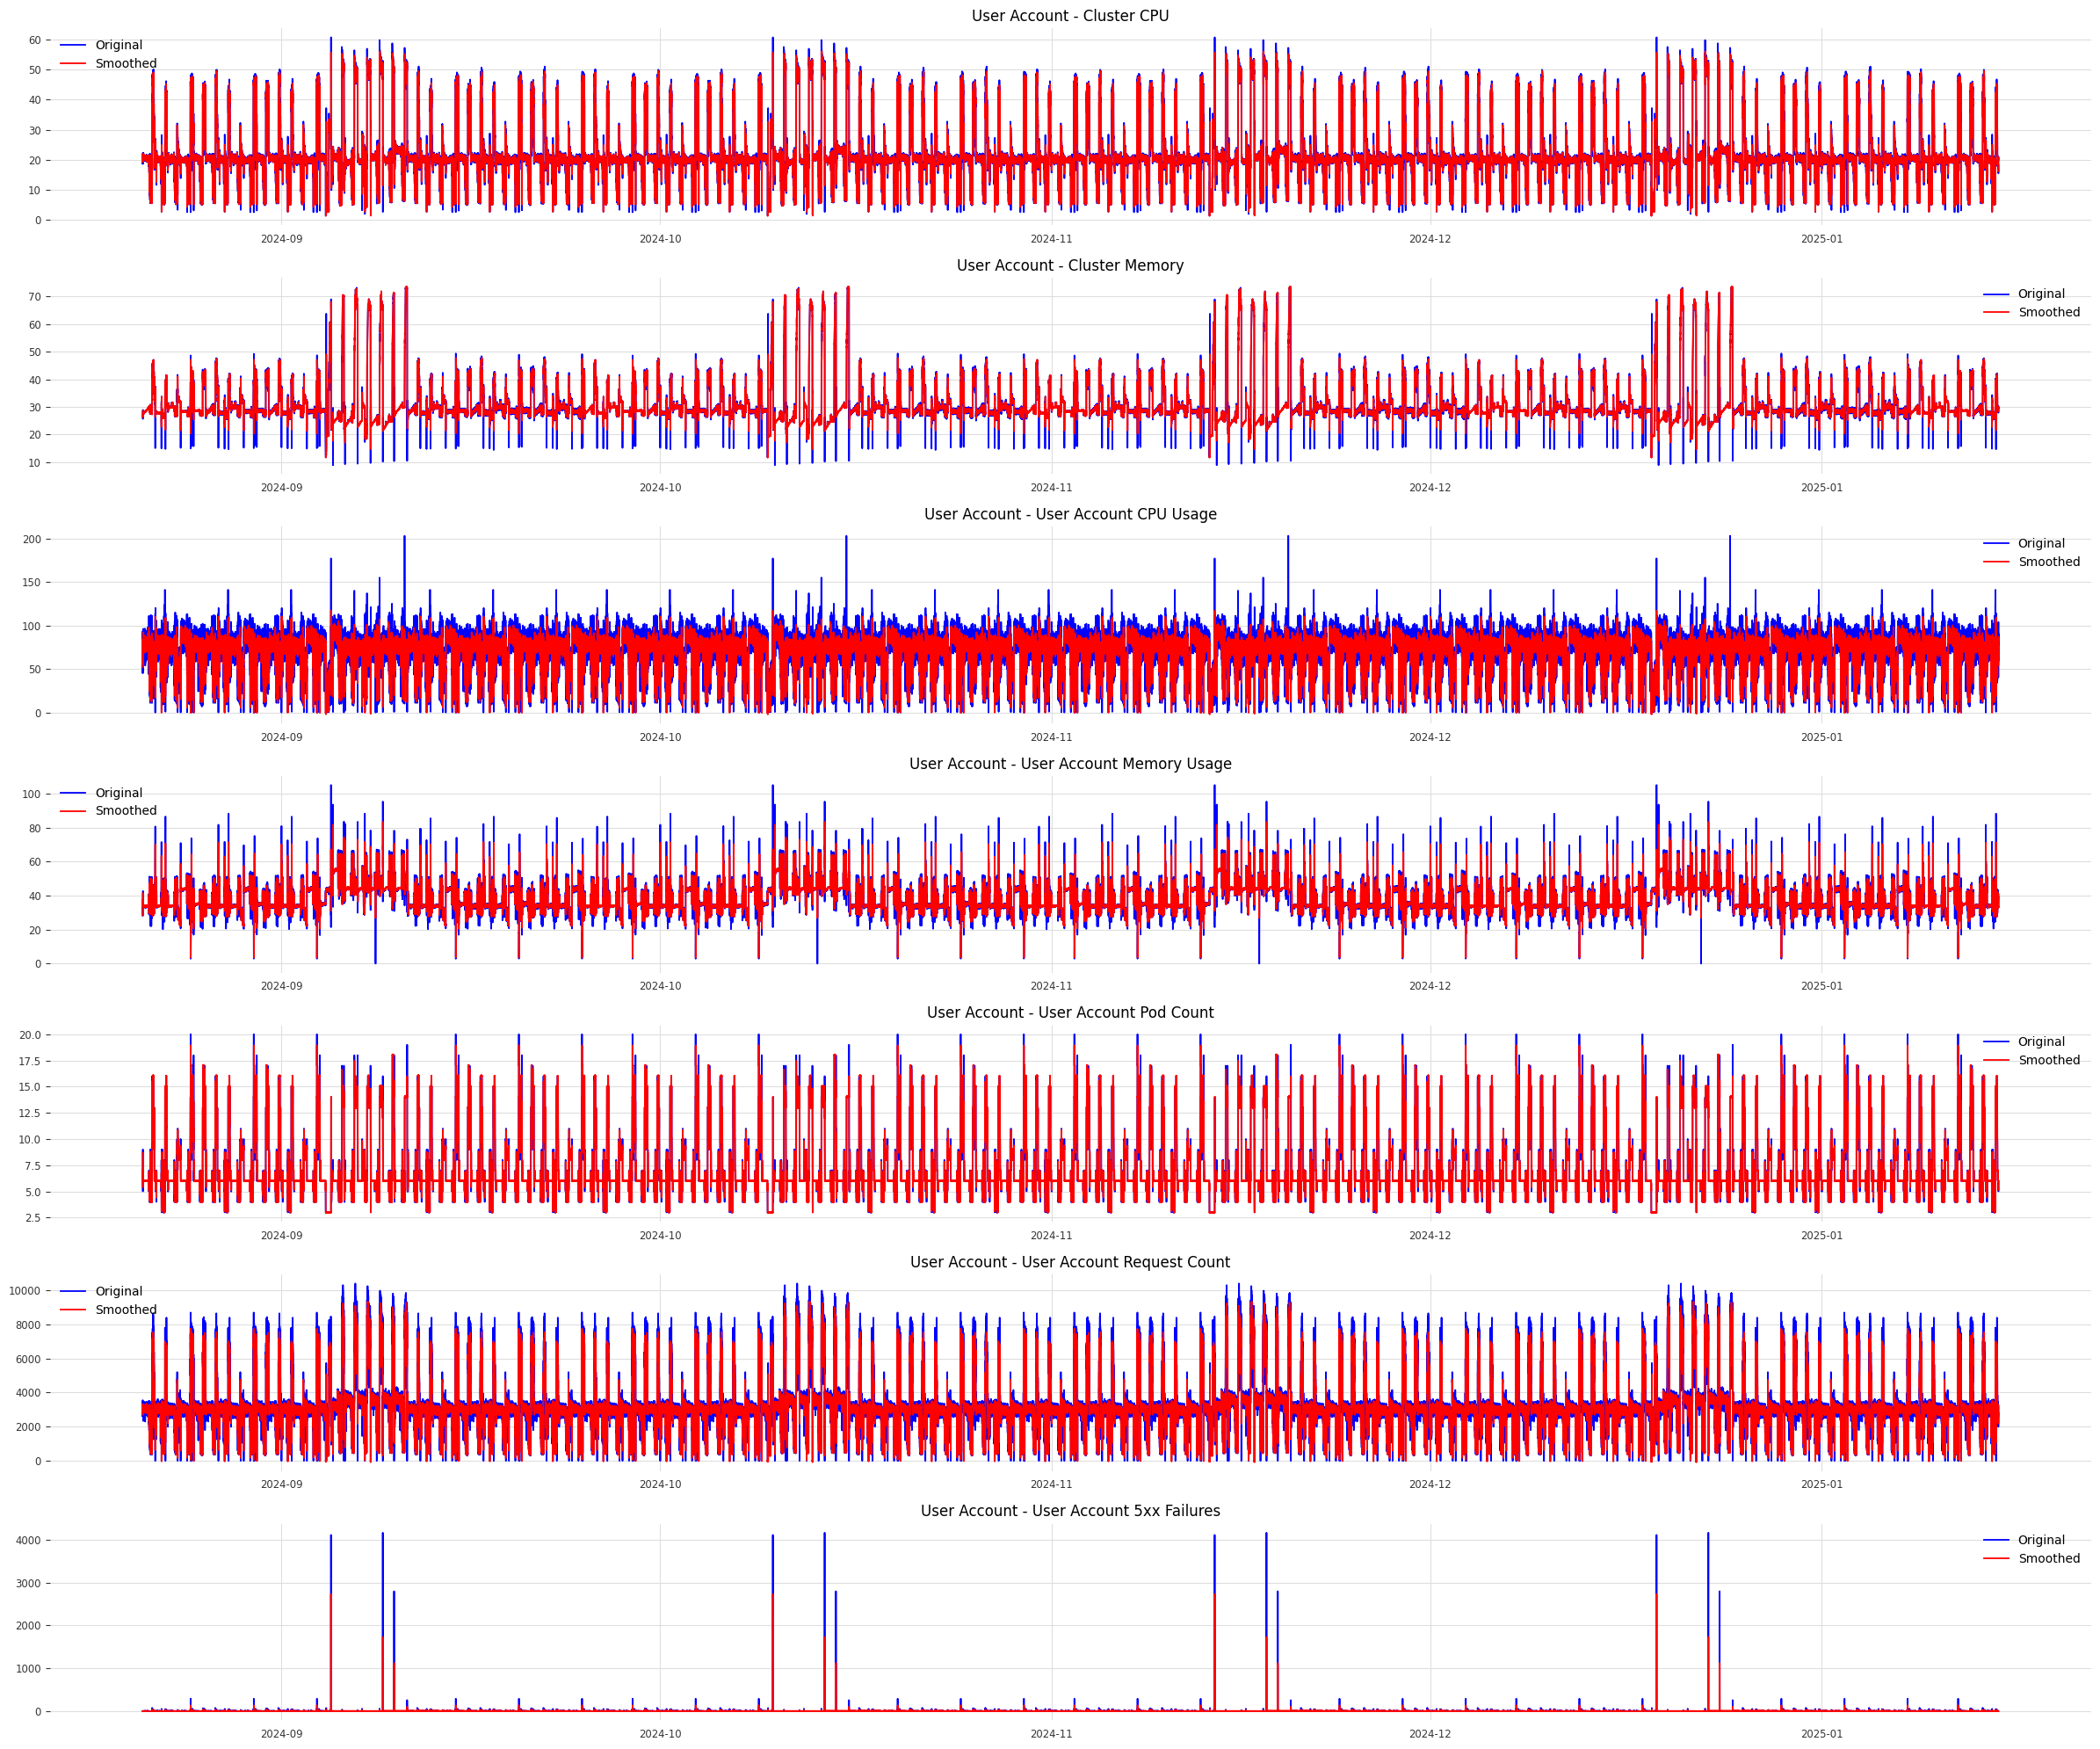

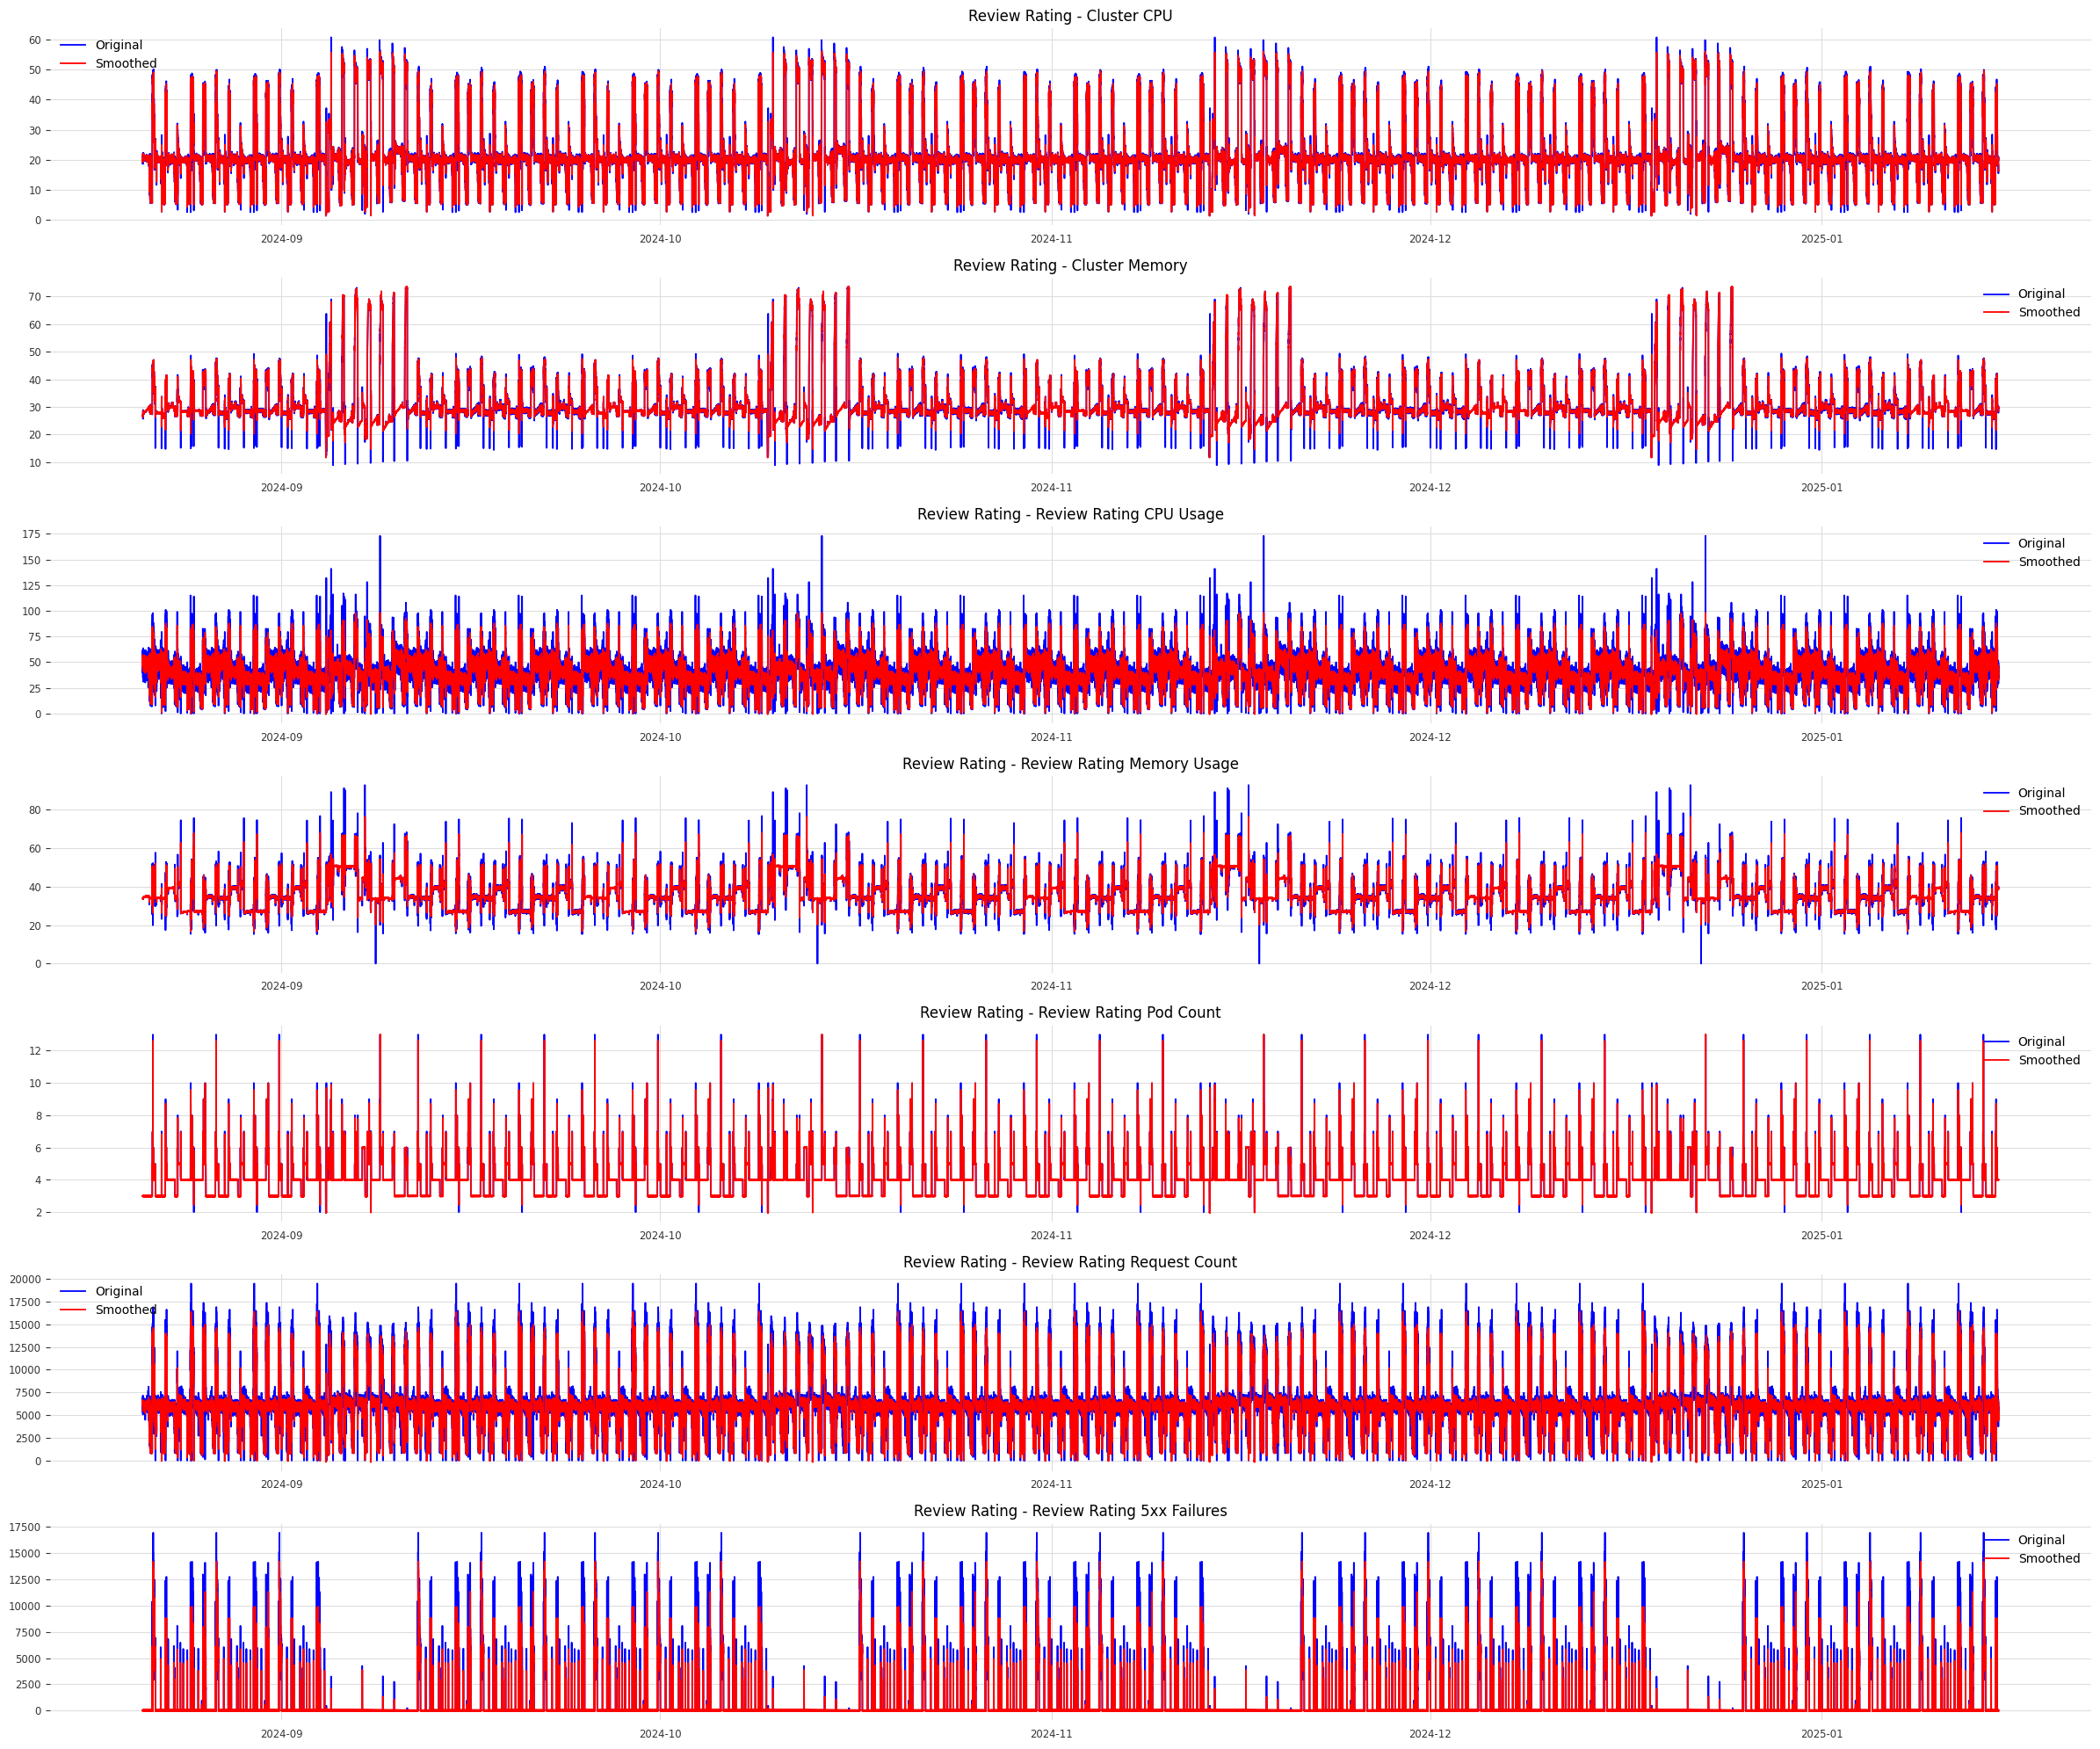

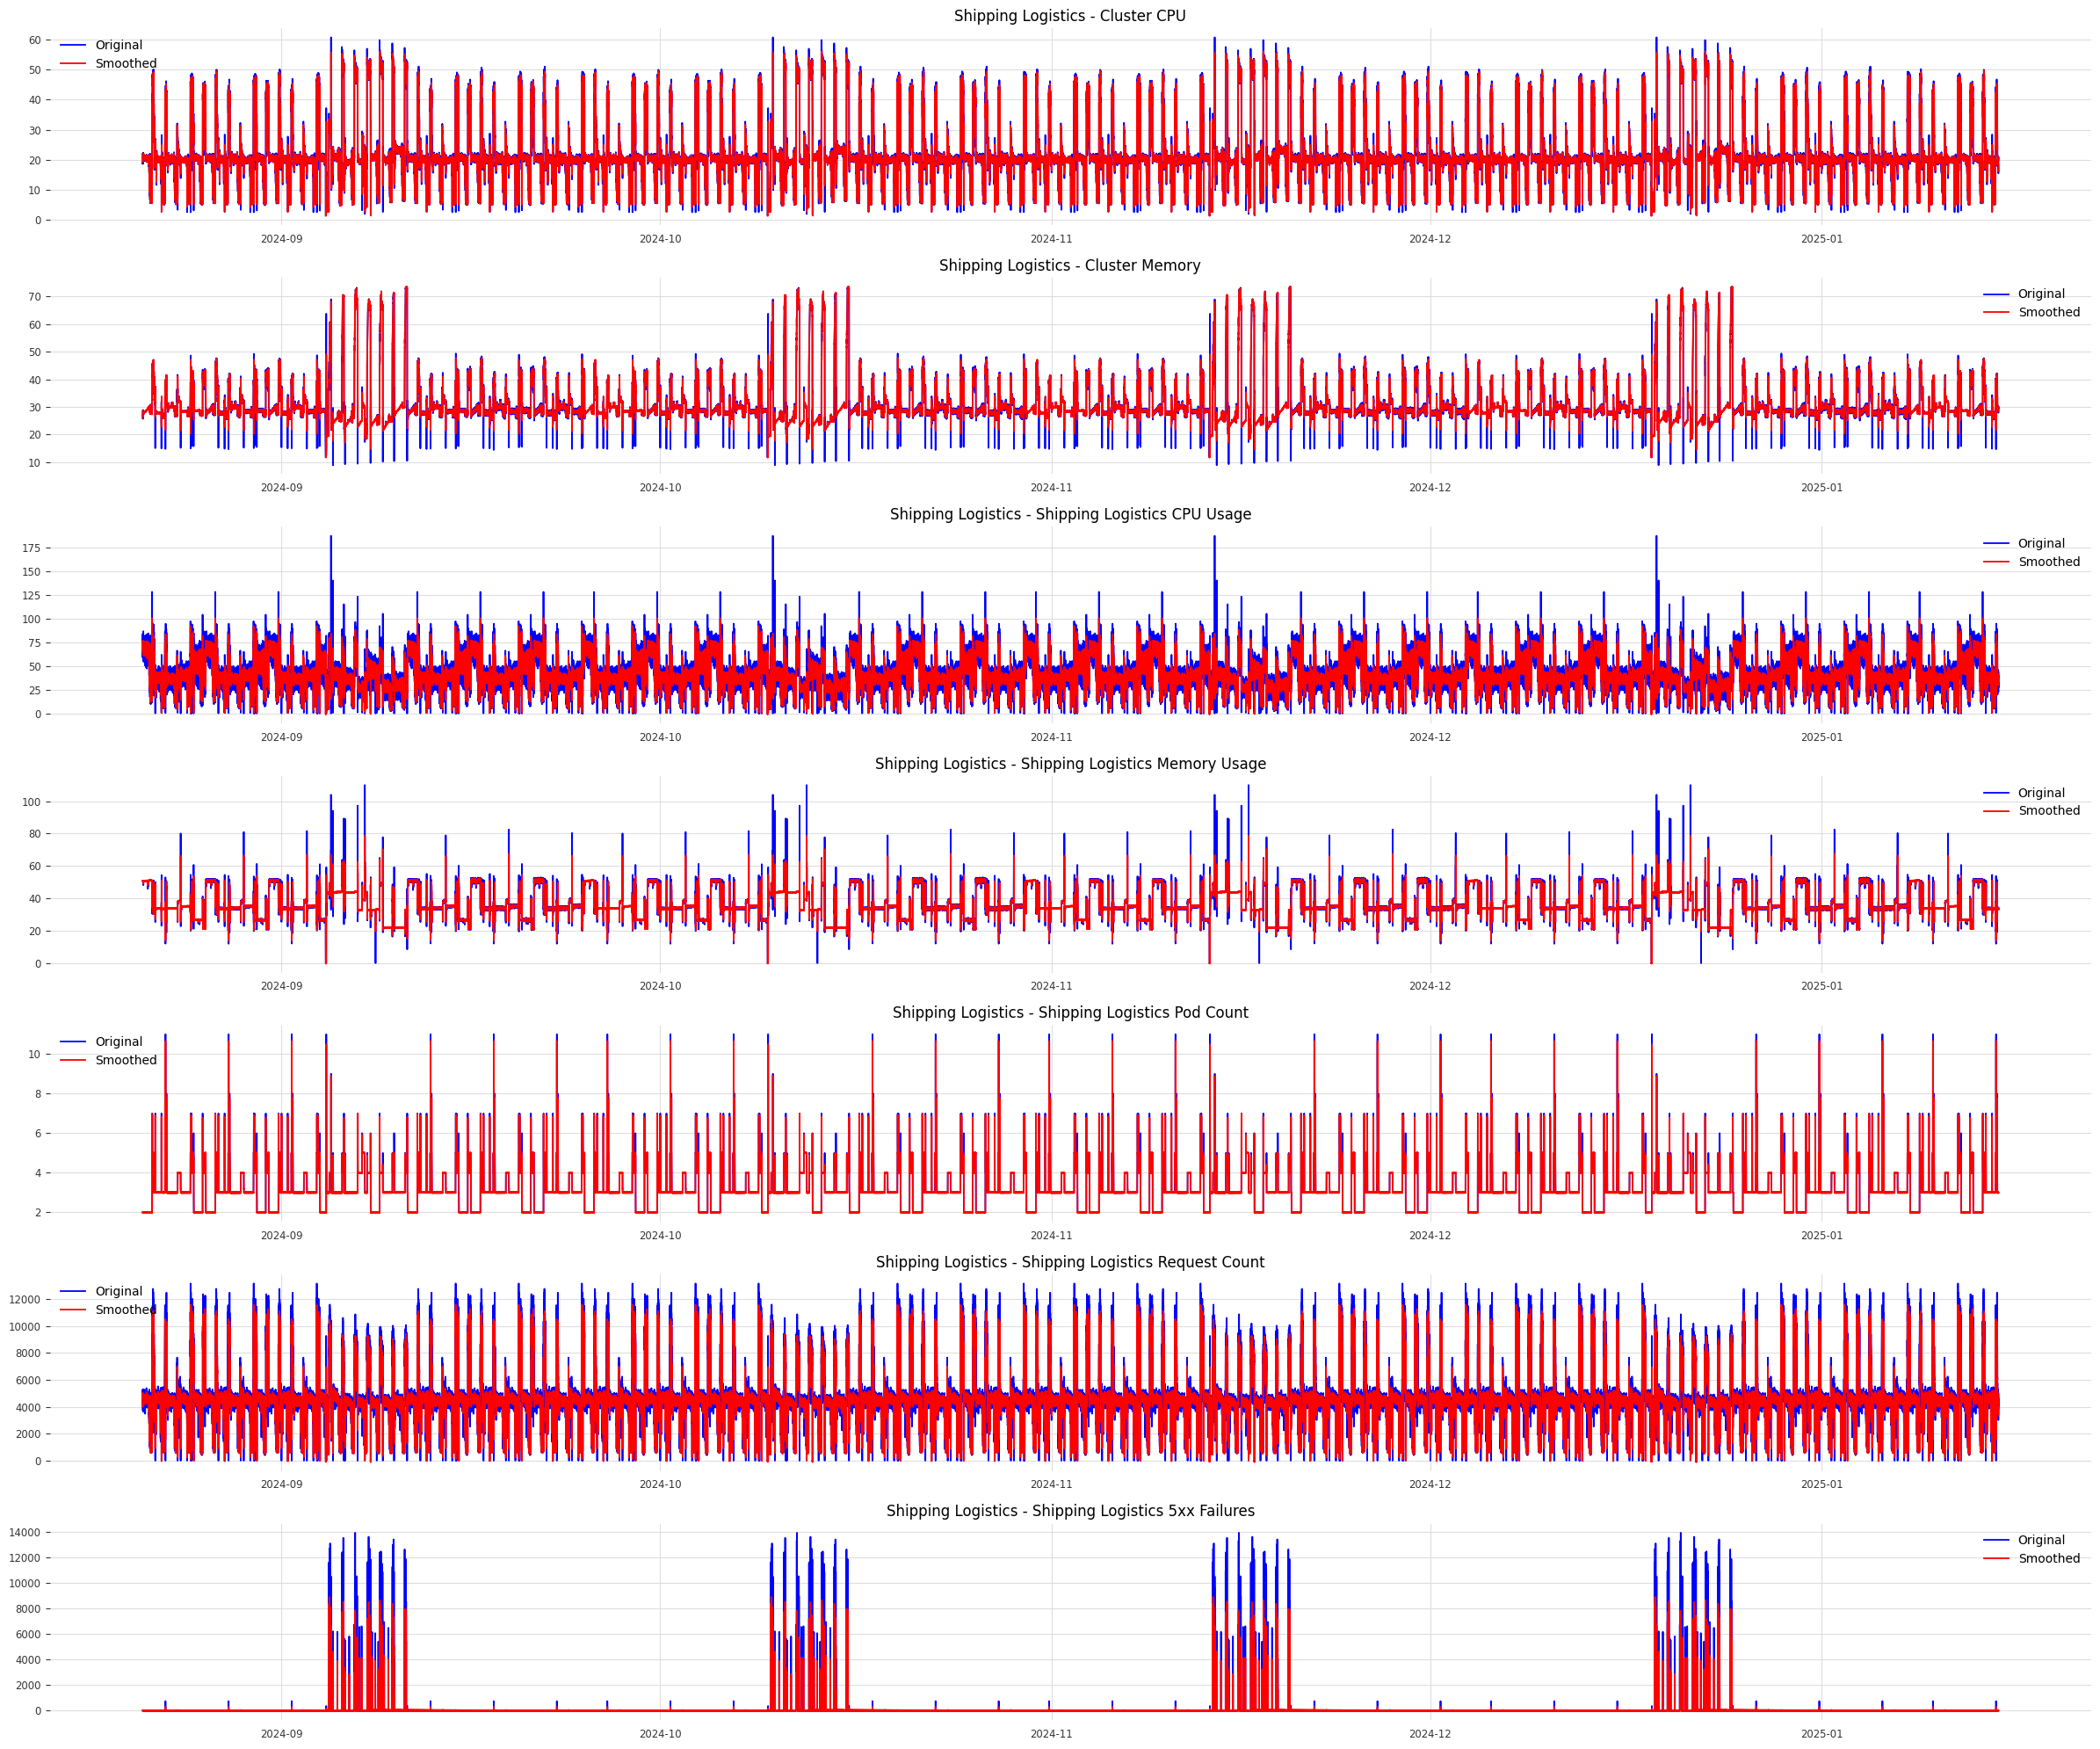

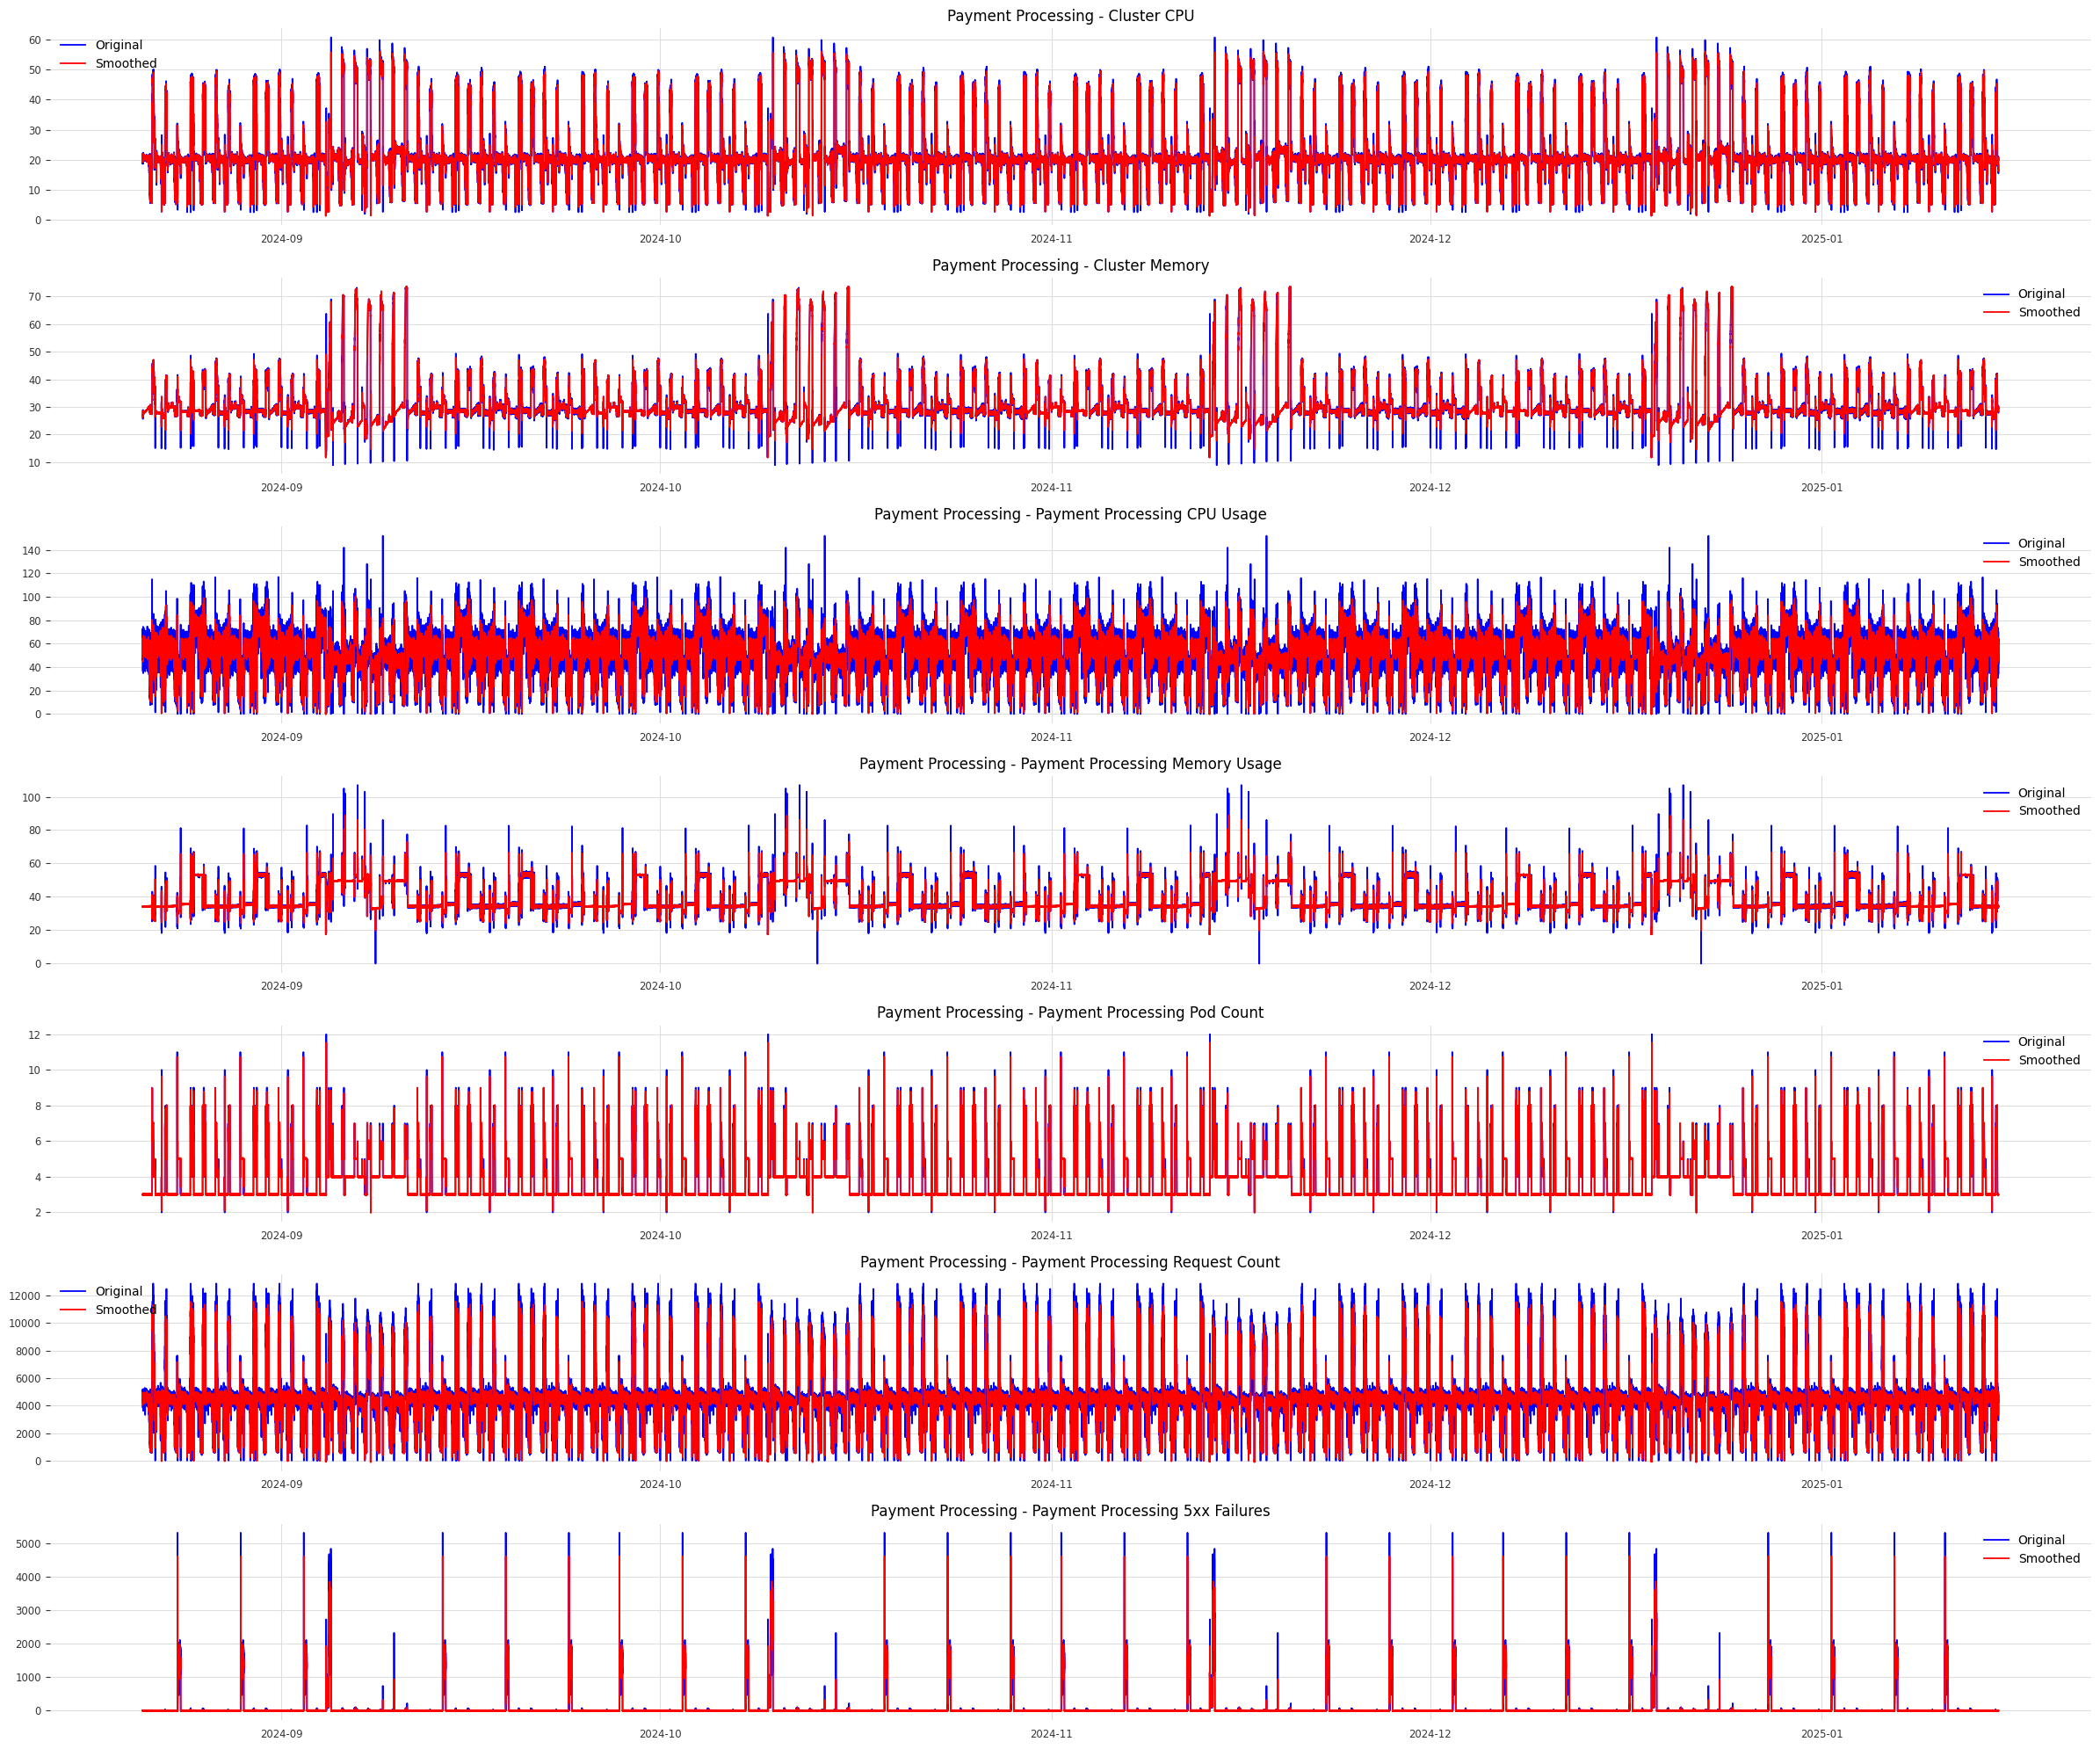

In [15]:

# Function to apply triple exponential smoothing on each column
def apply_triple_exponential_smoothing(df, seasonal_periods, trend_type='add', seasonal_type='add'):
    smoothed_df = pd.DataFrame(index=df.index)
    
    for column in df.columns:
        if column != 'Time':  # Avoid applying smoothing to the 'Time' column
            model = ExponentialSmoothing(df[column],
                                         trend=trend_type,
                                         seasonal=seasonal_type,
                                         seasonal_periods=seasonal_periods)
            smoothed_series = model.fit(smoothing_level=0.4, smoothing_trend=0.001, smoothing_seasonal=0.001).fittedvalues
            smoothed_df[column] = smoothed_series
            
    return smoothed_df

def plot_original_vs_smoothed(df, smoothed_df, title):
    plt.figure(figsize=(24, 20))
    columns = df.columns[:-1]  # Exclude 'Time' column
    
    for i, column in enumerate(columns, start=1):
        plt.subplot(7, 1, i)  # Adjust the subplot grid if necessary
        plt.plot(df.index, df[column], label='Original', color='blue')  # Use df.index for Time
        plt.plot(smoothed_df.index, smoothed_df[column], label='Smoothed', color='red')  # Use smoothed_df.index
        plt.title(f"{title} - {column}")
        plt.legend()

    plt.tight_layout()
    # plt.savefig(f"{title} - Denoising")
    plt.show()

seasonal_periods = 24

# Apply smoothing and visualize for each service
order_smoothed = apply_triple_exponential_smoothing(order_df, seasonal_periods)
plot_original_vs_smoothed(order_df, order_smoothed, 'Order Management')

product_smoothed = apply_triple_exponential_smoothing(product_df, seasonal_periods)
plot_original_vs_smoothed(product_df, product_smoothed, 'Product Catalog')

user_smoothed = apply_triple_exponential_smoothing(user_df, seasonal_periods)
plot_original_vs_smoothed(user_df, user_smoothed, 'User Account')

reviews_smoothed = apply_triple_exponential_smoothing(reviews_df, seasonal_periods)
plot_original_vs_smoothed(reviews_df, reviews_smoothed, 'Review Rating')

shipping_smoothed = apply_triple_exponential_smoothing(shipping_df, seasonal_periods)
plot_original_vs_smoothed(shipping_df, shipping_smoothed, 'Shipping Logistics')

payment_smoothed = apply_triple_exponential_smoothing(payment_df, seasonal_periods)
plot_original_vs_smoothed(payment_df, payment_smoothed, 'Payment Processing')

order_smoothed['Time'] = order_smoothed.index
product_smoothed['Time'] = product_smoothed.index
user_smoothed['Time'] = user_smoothed.index
reviews_smoothed['Time'] = reviews_smoothed.index
shipping_smoothed['Time'] = shipping_smoothed.index
payment_smoothed['Time'] = payment_smoothed.index

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `order_smoothed` is your DataFrame
# Define thresholds for scaling decisions
cpu_upper_threshold = 50  # Percent for scaling up
cpu_lower_threshold = 25  # Percent for scaling down
memory_upper_threshold = 50  # Percent for scaling up
memory_lower_threshold = 25  # Percent for scaling down
request_threshold = 8000  # Request count
failure_threshold = 0  # 5xx failures should ideally be non-negative

# Create a new column for Scaling Action
order_smoothed['Scaling Action'] = 'No Action'

# Iterate through the DataFrame to analyze each time point
for i in range(len(order_smoothed)):
    cluster_cpu = order_smoothed['Cluster CPU'].iloc[i]
    cluster_memory = order_smoothed['Cluster Memory'].iloc[i]
    pod_count = order_smoothed['Order Management Pod Count'].iloc[i]
    request_count = order_smoothed['Order Management Request Count'].iloc[i]
    failure_count = order_smoothed['Order Management 5xx Failures'].iloc[i]

    # Calculate service CPU and memory utilization (multiplied by pod count)
    service_cpu_usage = order_smoothed['Order Management CPU Usage'].iloc[i] * pod_count
    service_memory_usage = order_smoothed['Order Management Memory Usage'].iloc[i] * pod_count

    # Adjusted thresholds
    adjusted_cpu_upper_threshold = cpu_upper_threshold * pod_count
    adjusted_cpu_lower_threshold = cpu_lower_threshold * pod_count
    adjusted_memory_upper_threshold = memory_upper_threshold * pod_count
    adjusted_memory_lower_threshold = memory_lower_threshold * pod_count

    # Vertical Scaling Decision
    if service_cpu_usage > adjusted_cpu_upper_threshold or service_memory_usage > adjusted_memory_upper_threshold:
        order_smoothed['Scaling Action'].iloc[i] = 'Vertical Upscale'
    elif service_cpu_usage < adjusted_cpu_lower_threshold and pod_count > 1:
        order_smoothed['Scaling Action'].iloc[i] = 'Vertical Downscale'

    # Horizontal Scaling Decision
    if request_count > request_threshold or failure_count < failure_threshold:
        order_smoothed['Scaling Action'].iloc[i] = 'Horizontal Upscale'
    elif request_count < (request_threshold * 0.8) and pod_count > 1:  # Example condition for downscale
        order_smoothed['Scaling Action'].iloc[i] = 'Horizontal Downscale'

    # Logging progress after every 1000 records
    if i % 1000 == 0 and i != 0:
        print(f"Processed {i} records so far...")

# Print the updated DataFrame
print("Processing complete.")

Processed 1000 records so far...
Processed 2000 records so far...
Processed 3000 records so far...
Processed 4000 records so far...
Processed 5000 records so far...
Processed 6000 records so far...
Processed 7000 records so far...
Processed 8000 records so far...
Processed 9000 records so far...
Processed 10000 records so far...
Processed 11000 records so far...
Processed 12000 records so far...
Processed 13000 records so far...
Processed 14000 records so far...
Processed 15000 records so far...
Processed 16000 records so far...
Processed 17000 records so far...
Processed 18000 records so far...
Processed 19000 records so far...
Processed 20000 records so far...
Processed 21000 records so far...
Processed 22000 records so far...
Processed 23000 records so far...
Processed 24000 records so far...
Processed 25000 records so far...
Processed 26000 records so far...
Processed 27000 records so far...
Processed 28000 records so far...
Processed 29000 records so far...
Processed 30000 records

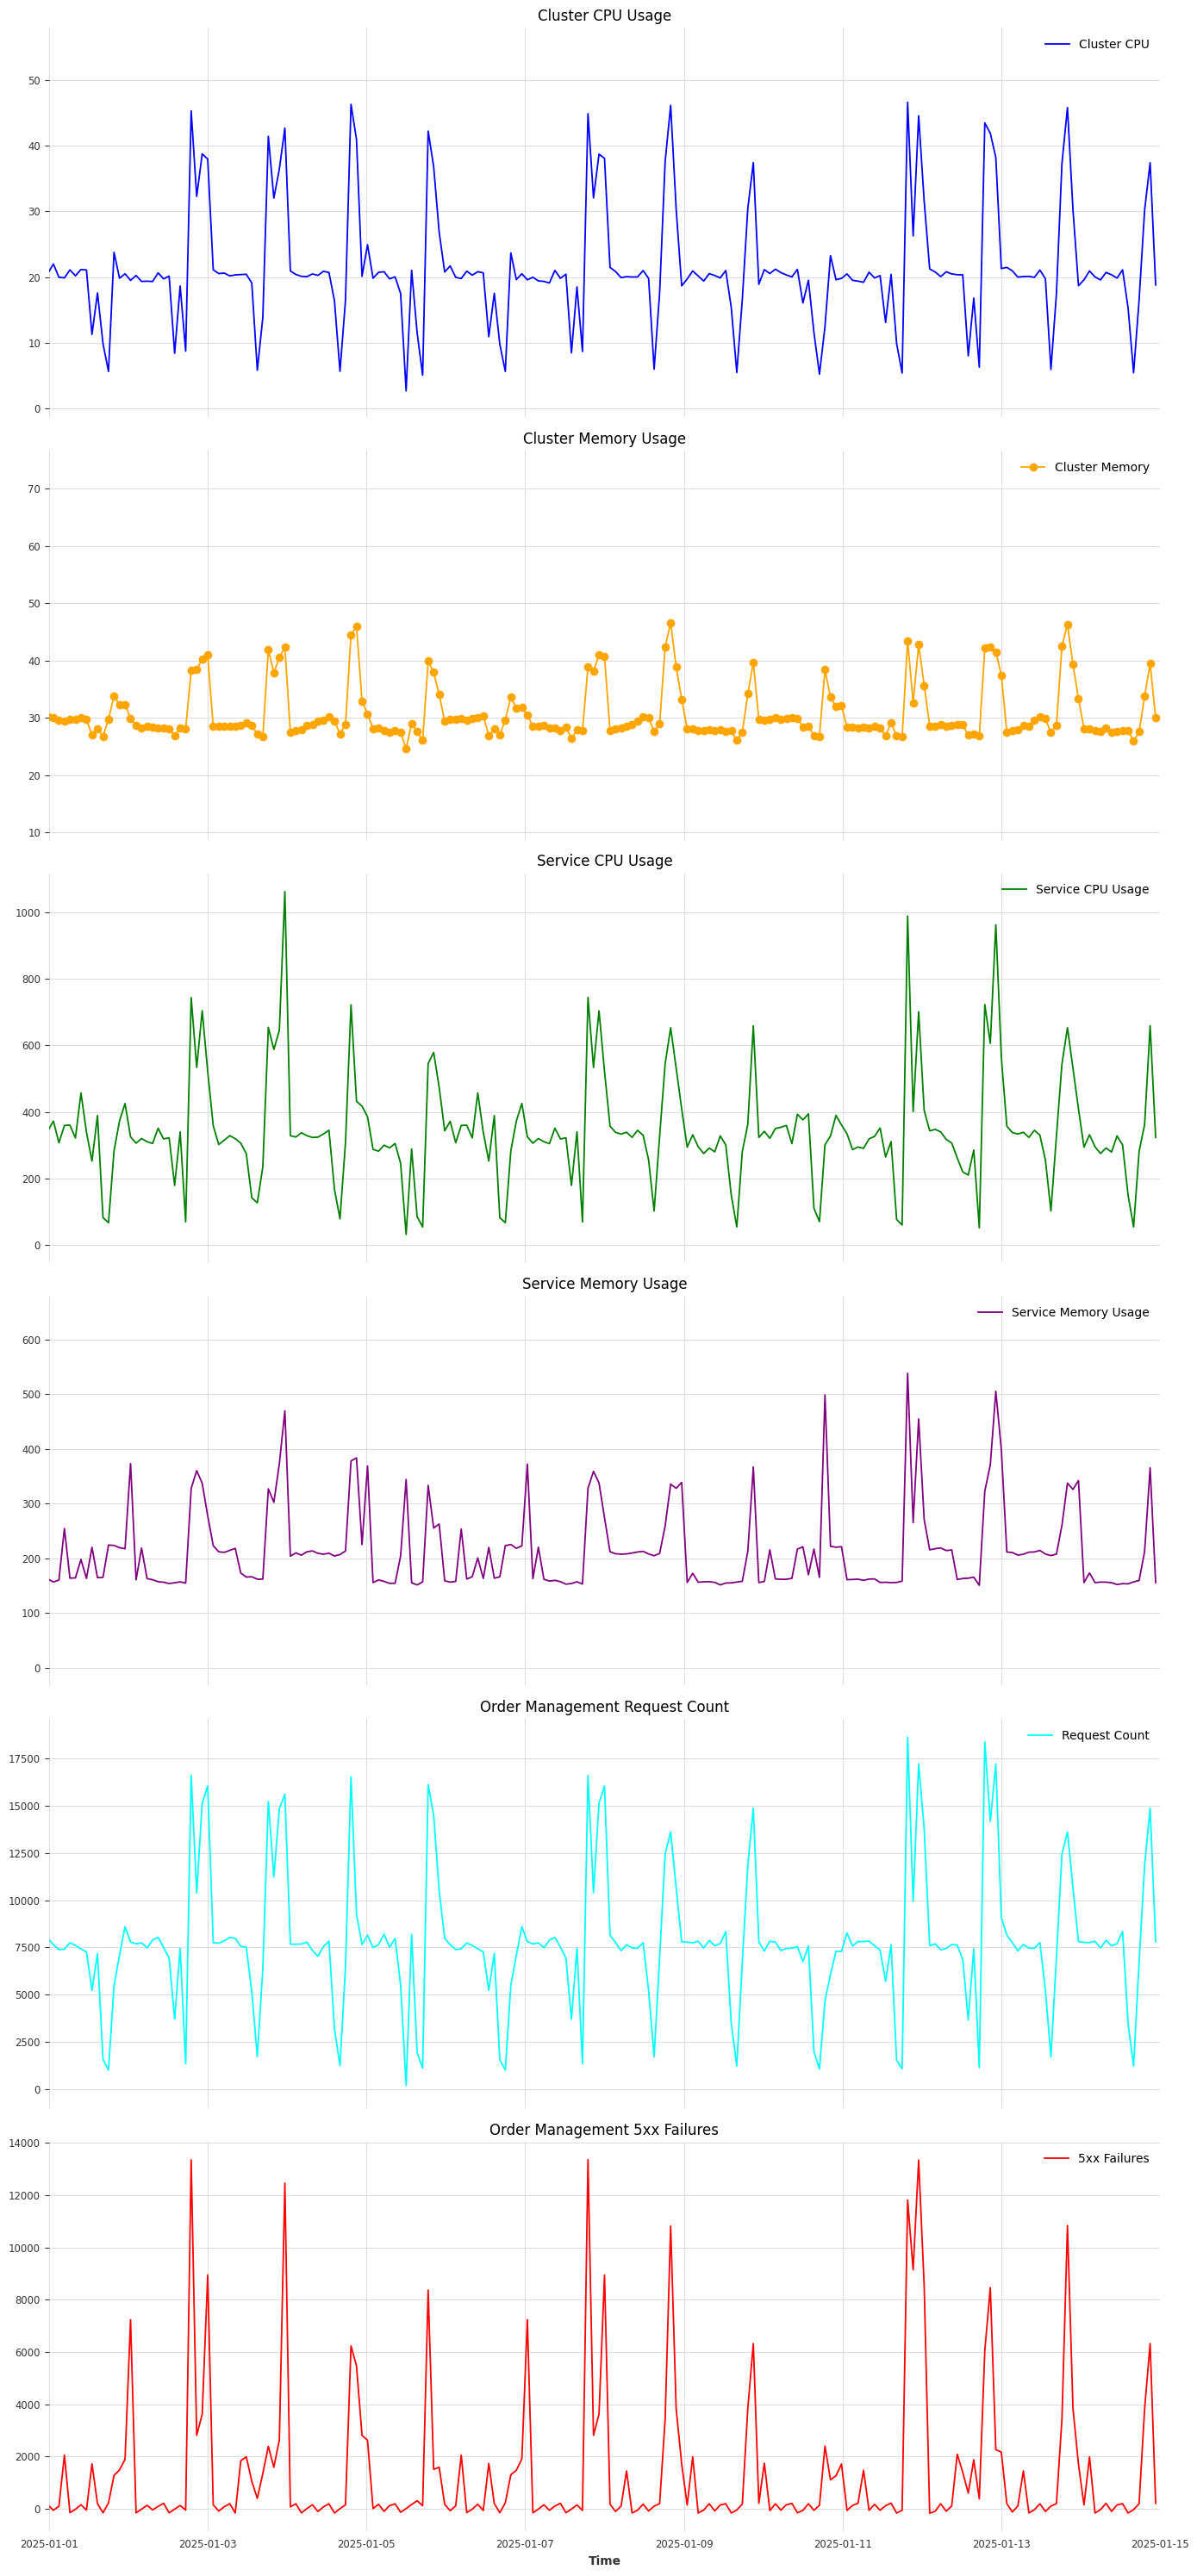

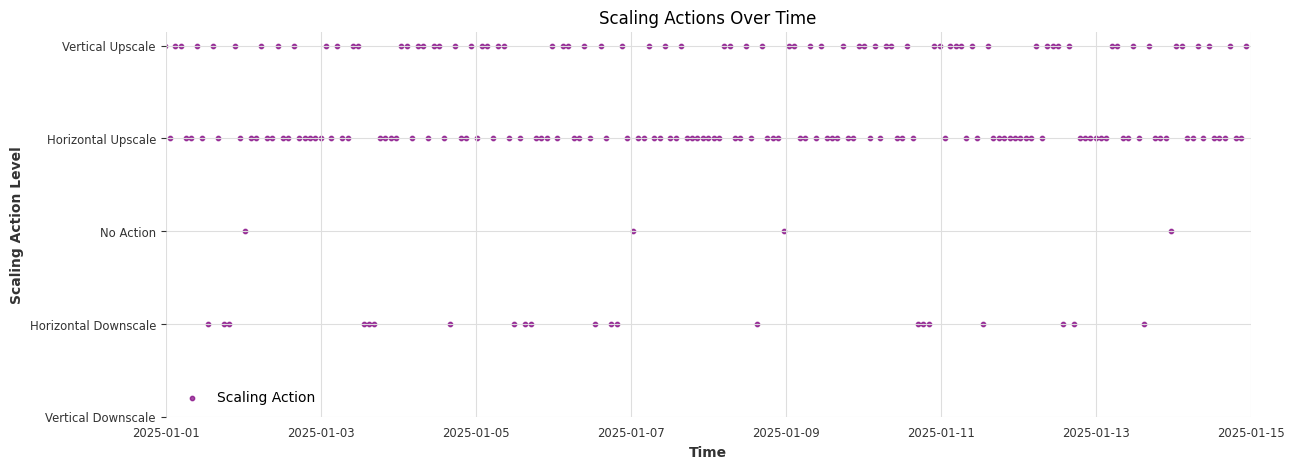

In [23]:
import matplotlib.pyplot as plt

# Convert the index to datetime if not already in that format
plot_data = order_smoothed[::100]
plot_data.index = pd.to_datetime(plot_data.index)

# Define the date range for the x-axis limits
start_date = '2025-01-01'
end_date = '2025-01-15'

# Create a figure for the metrics
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(14, 30), sharex=True)

# Cluster CPU
axes[0].plot(plot_data.index, plot_data['Cluster CPU'], label='Cluster CPU', color='blue')
axes[0].set_title('Cluster CPU Usage')
axes[0].legend()
axes[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Cluster Memory
axes[1].plot(plot_data.index, plot_data['Cluster Memory'], label='Cluster Memory', color='orange', marker='o')
axes[1].set_title('Cluster Memory Usage')
axes[1].legend()
axes[1].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Service CPU Usage (adjusted)
axes[2].plot(plot_data.index, plot_data['Order Management CPU Usage'] * plot_data['Order Management Pod Count'], label='Service CPU Usage', color='green')
axes[2].set_title('Service CPU Usage')
axes[2].legend()
axes[2].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Service Memory Usage (adjusted)
axes[3].plot(plot_data.index, plot_data['Order Management Memory Usage'] * plot_data['Order Management Pod Count'], label='Service Memory Usage', color='purple')
axes[3].set_title('Service Memory Usage')
axes[3].legend()
axes[3].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Order Management Request Count
axes[4].plot(plot_data.index, plot_data['Order Management Request Count'], label='Request Count', color='cyan')
axes[4].set_title('Order Management Request Count')
axes[4].legend()
axes[4].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Order Management 5xx Failures
axes[5].plot(plot_data.index, plot_data['Order Management 5xx Failures'], label='5xx Failures', color='red')
axes[5].set_title('Order Management 5xx Failures')
axes[5].legend()
axes[5].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Set xlabel for all subplots
plt.xlabel('Time')

# Adjust the layout
plt.tight_layout()

# Show the metrics plots
plt.show()

# Now let's create a separate plot for Scaling Action
scaling_fig, scaling_ax = plt.subplots(figsize=(14, 5))

# Mapping actions to y-coordinates
action_map = {
    'No Action': 0,
    'Horizontal Upscale': 1,
    'Vertical Upscale': 2,
    'Horizontal Downscale': -1,
    'Vertical Downscale': -2
}

# Apply the action map to get the height levels for scaling actions
scaling_actions = plot_data['Scaling Action'].map(action_map)

# Scatter plot for Scaling Actions
scaling_ax.scatter(plot_data.index, scaling_actions, color='purple', marker='o', s=10, label='Scaling Action', alpha=0.7)

# Set x-axis limits for scaling actions
scaling_ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Add labels and formatting
scaling_ax.set_title('Scaling Actions Over Time')
scaling_ax.set_yticks([-2, -1, 0, 1, 2])
scaling_ax.set_yticklabels(['Vertical Downscale', 'Horizontal Downscale', 'No Action', 'Horizontal Upscale', 'Vertical Upscale'])
scaling_ax.set_xlabel('Time')
scaling_ax.set_ylabel('Scaling Action Level')
scaling_ax.legend()

# Show the scaling actions plot
plt.show()
